In [13]:
from PIL import Image, ImageEnhance
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os


## Increase contrast of site

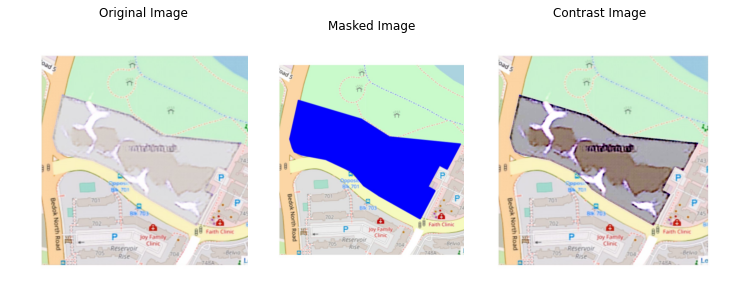

In [14]:
directory_path = os.getcwd()

mask_image = Image.open(os.path.join(directory_path, 'test_mask_1.jpg'))
original_image = Image.open(os.path.join(directory_path, 'test_gen_1.jpg'))

mask_array = np.array(mask_image)
original_array = np.array(original_image)

# Create mask using blue mask
def create_binary_mask(arr, target_color, threshold=30):
    lower_bound = np.array(target_color) - threshold
    upper_bound = np.array(target_color) + threshold
    mask = (arr[:, :, :3] >= lower_bound) & (arr[:, :, :3] <= upper_bound)
    return np.all(mask, axis=-1)
mask_color = [0, 0, 255]  # bright blue
site_mask = create_binary_mask(mask_array, mask_color)

# Extract site from the original image that corresponds to the blue mask
site_area = original_array.copy()
site_area[~site_mask] = [255, 255, 255]  # making non-masked region white

# Convert site_area back to a PIL image and enhance its contrast
site_area_image = Image.fromarray(site_area)
enhancer = ImageEnhance.Contrast(site_area_image)
enhanced_site = enhancer.enhance(3.0) # amount of contrast
enhanced__site_array = np.array(enhanced_site)

# Combine the enhanced region with the original image
original_contrast_array = original_array.copy()
original_contrast_array[site_mask] = enhanced__site_array[site_mask]
contrast_image = Image.fromarray(original_contrast_array)

# Display the result
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title('Original Image')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(mask_image)
plt.title('Masked Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(contrast_image)
plt.title('Contrast Image')
plt.axis('off')
plt.show()


## Extract Buildings

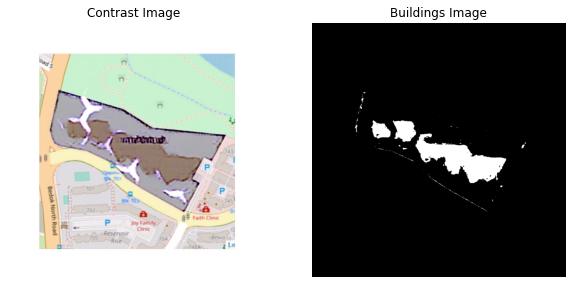

In [15]:
def extract_brown_regions(input_array):
    image = cv2.cvtColor(input_array, cv2.COLOR_RGB2BGR)
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lower_brown = np.array([5, 50, 20])
    upper_brown = np.array([25, 255, 220])
    mask = cv2.inRange(hsv, lower_brown, upper_brown)
    return mask

# Create a mask for brown regions
brown_mask = extract_brown_regions(original_contrast_array)

# Mask for brown regions in the blue mask area
brown_blue_mask = cv2.bitwise_and(brown_mask, brown_mask, mask=site_mask.astype(np.uint8)*255)

buildings_image = Image.fromarray(brown_blue_mask)

# Display the result
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(contrast_image)
plt.title('Contrast Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(buildings_image, cmap='gray')
plt.title('Buildings Image')
plt.axis('off')
plt.show()

##  Draw contours

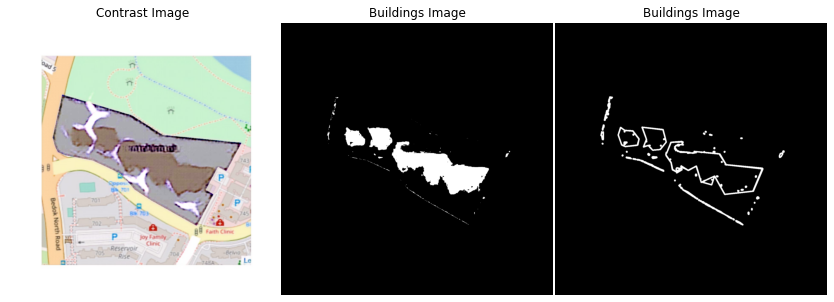

In [16]:
def approx_contours(contours, epsilon_factor=0.02):
    approximated_contours = []
    for contour in contours:
        epsilon = epsilon_factor * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        approximated_contours.append(approx)
    return approximated_contours

# Apply GaussianBlur to reduce noise and improve edge detection
blurred = cv2.GaussianBlur(brown_blue_mask, (5, 5), 0)

# Use Canny edge detection
edges = cv2.Canny(blurred, 50, 150)

# Find contours
contours, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Approximate contours to simplify shapes
approximated_contours = approx_contours(contours)

# Draw the contours on the original image
original_approximated_contours = cv2.drawContours(brown_blue_mask.copy(), approximated_contours, -1, (255), 10)

# Draw the contours on the blank image
blank_image = np.zeros_like(brown_blue_mask)
approximated_contours_image = cv2.drawContours(blank_image, approximated_contours, -1, (255), 5)

plt.figure(figsize=(18, 5))
plt.subplot(1, 2, 1)
plt.imshow(contrast_image)
plt.title('Contrast Image')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(buildings_image, cmap='gray')
plt.title('Buildings Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(approximated_contours_image, cmap='gray')
plt.title('Buildings Image')
plt.axis('off')
plt.show()


## Clean up contours
- clear small contours, combine close contours(dialate), clear small contours

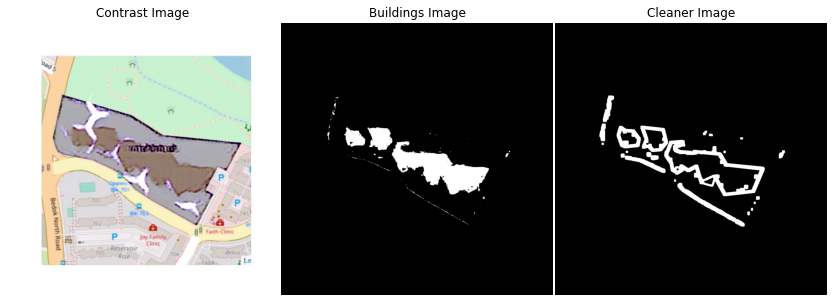

In [17]:
# # Draw the 'approximated' contours on another blank image
blank_image = np.zeros((brown_blue_mask.shape[0], brown_blue_mask.shape[1]), dtype=np.uint8)
clean_image = cv2.drawContours(blank_image, approximated_contours, -1, (255), thickness=5)

# Remove contours with small areas
for contour in approximated_contours:
    if cv2.contourArea(contour) < 2000:  # Adjust this threshold value as required
        cv2.drawContours(clean_image, [contour], -1, (0), thickness=cv2.FILLED)

# plt.imshow(clean_image, cmap='gray')
# plt.show()

# Dilate the contours to join close contours
kernel_size = 10  # Adjust based on the spacing between your contours
kernel = np.ones((kernel_size, kernel_size), np.uint8)
dilated_image = cv2.dilate(clean_image, kernel, iterations=1)

# Get contours from the dilated image
contours_dilated, _ = cv2.findContours(dilated_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Fill the contours from the dilated image to create solid shapes
filled_image = np.zeros_like(dilated_image)
cv2.drawContours(filled_image, contours_dilated, -1, (255), thickness=cv2.FILLED)

# plt.imshow(filled_image, cmap='gray')
# plt.show()

# Remove contours with small areas
for contour in contours_dilated:
    if cv2.contourArea(contour) < 1200:  # Adjust this threshold value as required
        cv2.drawContours(filled_image, [contour], -1, (0), 5)

# plt.imshow(filled_image, cmap='gray')
# plt.show()

plt.figure(figsize=(18, 5))
plt.subplot(1, 2, 1)
plt.imshow(contrast_image)
plt.title('Contrast Image')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(buildings_image, cmap='gray')
plt.title('Buildings Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(filled_image, cmap='gray')
plt.title('Cleaner Image')
plt.axis('off')
plt.show()



## Remove contours at edge

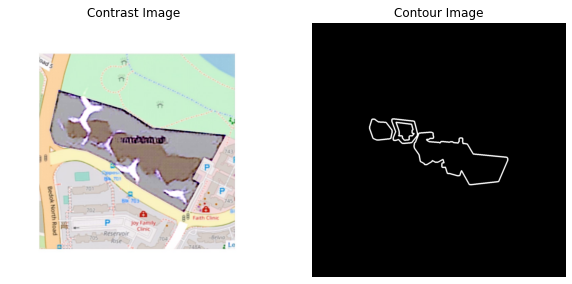

In [18]:
def centroid(contour):
    M = cv2.moments(contour)
    if M["m00"] == 0:
        return None
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])
    return (cX, cY)

# Filter out contours that are too close to the boundaries
filtered_contours = []
for contour in contours_dilated:
    c = centroid(contour)
    if c is None:
        continue
    distances = [np.linalg.norm(np.array(c) - point[0]) for point in contour]
    min_distance = min(distances)
    if min_distance >=30:  # Distance
        filtered_contours.append(contour)

blank_image = np.zeros((brown_blue_mask.shape[0], brown_blue_mask.shape[1]), dtype=np.uint8)
final_contour_image = cv2.drawContours(blank_image, filtered_contours, -1, (255), 5) #thickness=cv2.FILLED

#cv2.imwrite("test_3_clean.jpg", final_contour_image)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(contrast_image)
plt.title('Contrast Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(final_contour_image, cmap='gray')
plt.title('Contour Image')
plt.axis('off')
plt.show()
